<a href="https://www.kaggle.com/code/minhbtnguyen/presidential-election-prediction-via-us-census?scriptVersionId=126839553" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Presidential Election using Decision Tree with Sklearn

**Note:** In the history of the US election, there are only two dominant parties, Democrates and Republicans, that win the elections every 4 years. Thus we will do binary classification. As our team looks at the census data in the counties level, to make the prediction process easier, we will choose the party with most counties counts as a "winning candidate" in a year instead of considering both "Population Votes" and "Electoral College Votes".

**Note:** *This notebook is for data science practice only, no political purpose in mind.*

![](https://ichef.bbci.co.uk/news/976/cpsprodpb/4081/production/_114631561_debates_index_promo976.png)

# 1. Data Processing

In [1]:
# import general libraries
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

# import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree

In [2]:
# import dataset
df = pd.read_csv('/kaggle/input/us-census-for-election-predictions-20002020/county_census_and_election_result.csv')
df.head()

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,...,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2000,1,24566.4,634.6,46.0,46912.7,93.6,6.4,54.0,46.0,...,38.4,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2,33842.9,1080.1,42.4,65021.9,95.3,4.7,50.3,49.7,...,25.2,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,4,28331.7,814.7,45.3,52826.7,95.8,4.2,52.1,47.9,...,38.3,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,5,22782.6,557.5,46.2,43941.3,92.5,7.5,53.0,47.0,...,37.8,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,6,32245.0,1216.3,43.8,61455.3,95.7,4.3,52.0,48.0,...,35.1,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# check dataset dimension
print(f"The dimension of the dataset is: {df.shape}")

The dimension of the dataset is: (7526, 45)


In [4]:
# check data types of each columns
df.dtypes

year                      int64
county_fips               int64
inctot                  float64
mortamt1                float64
avrg_age                float64
ftotinc                 float64
foodstmp_1_freq         float64
foodstmp_2_freq         float64
sex_2_freq              float64
sex_1_freq              float64
marst_5_freq            float64
marst_6_freq            float64
marst_1_freq            float64
marst_4_freq            float64
marst_3_freq            float64
marst_2_freq            float64
race_1_freq             float64
race_2_freq             float64
race_7_freq             float64
race_8_freq             float64
race_5_freq             float64
race_6_freq             float64
race_3_freq             float64
race_4_freq             float64
race_9_freq             float64
ctz_stat_1_freq         float64
ctz_stat_3_freq         float64
ctz_stat_2_freq         float64
lang_1_freq             float64
lang_2_freq             float64
educ_attain_2.0_freq    float64
educ_att

## 1.1. Process Original Dataset

In [5]:
# select the rows in the dataset that have the voting labels (years 2008, 2012, 2016, 2020)
selected_df = df.loc[df['year'].isin([2008, 2012, 2016, 2020])]

# reset index
selected_df = selected_df.reset_index(drop=True)

# view the dataset
selected_df

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,...,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2008,1000,22523.9,591.8,47.0,44879.5,90.6,9.4,53.4,46.6,...,41.6,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,...,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
2,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,...,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
3,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,...,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
4,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,...,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,...,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
1854,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,...,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
1855,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,...,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0
1856,2020,55139,25796.1,667.3,45.9,49219.4,93.5,6.5,47.9,52.1,...,41.5,1.6,WI,WINNEBAGO,44060.0,38.0,1629.0,509.0,47796.0,1.0


In [6]:
# check dataset dimension
print(f"The dimension of the dataset is: {df.shape}")

The dimension of the dataset is: (7526, 45)


In [7]:
# Examine and replace missing values 
print(selected_df.isnull().values.any())

True


**Note:** As we consider each row as a data point to our ML model, we will drop the categorical state names and abbreviation. We will also drop the all the number of votes labels except for "winner" columns (0 for democrats and 1 for republican). We don't concern other parties as they do not have a history of winning anyway.

**Drop**:
- county_fips: as there is no correlation between fips and vote numbers.
- state_po: as there is no correlation between state appreviation and vote numbers.
- county_name: as there is no correlation between county names and vote numbers.
- democrat: as we do classification task.
- green: as we do classification task.
- liberitarian: as we do classification task.
- other: as we do classification task.
- republican: as we do classification task.

In [8]:
# Feature selection
more_selected_df = selected_df.drop(columns=['county_fips', 'state_po', 'county_name', 'democrat',
                                             'green', 'liberitarian', 'other', 'republican'])

more_selected_df.head()

,year,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,...,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,winner
0,2008,22523.9,591.8,47.0,44879.5,90.6,9.4,53.4,46.6,9.5,...,96.4,3.6,40.4,53.3,5.9,0.5,54.9,41.6,3.6,NaN
1,2008,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,...,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,1.0
2,2008,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,...,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,1.0
3,2008,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,...,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,1.0
4,2008,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,...,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,0.0


In [9]:
# fill the NaN with both forward and backward fills
more_selected_df = more_selected_df.fillna(method='ffill')
more_selected_df = more_selected_df.fillna(method='bfill')

In [10]:
# check if there is any NaN values
print(more_selected_df.isnull().values.any())

False


In [11]:
more_selected_df.head()

,year,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,...,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,winner
0,2008,22523.9,591.8,47.0,44879.5,90.6,9.4,53.4,46.6,9.5,...,96.4,3.6,40.4,53.3,5.9,0.5,54.9,41.6,3.6,1.0
1,2008,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,...,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,1.0
2,2008,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,...,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,1.0
3,2008,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,...,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,1.0
4,2008,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,...,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,0.0


In [12]:
print(f"The dimension of the dataset is: {more_selected_df.shape}")

The dimension of the dataset is: (1858, 37)


**Note:** divide the dataset into 2 datasets. Dataset 1 is within 2008, 2012, 2016 for machine learning modeling. Dataset 2 is of 2020 for testing the prediction power of the trained and validated data

## 1.2. Process The Dataset Of 2008, 2012, 2016 Election Years

In [13]:
# select rows with the years 2008, 2012, 2016 presidential election
df1 = more_selected_df.loc[more_selected_df['year'].isin([2008, 2012, 2016])]

# Model-dev 4: Feature selection
df1 = df1.drop(columns=['year'])

# reset index
df1 = df1.reset_index(drop=True)

# view the dataset
df1.head()

,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,...,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,winner
0,22523.9,591.8,47.0,44879.5,90.6,9.4,53.4,46.6,9.5,17.4,...,96.4,3.6,40.4,53.3,5.9,0.5,54.9,41.6,3.6,1.0
1,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,...,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,1.0
2,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,...,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,1.0
3,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,...,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,1.0
4,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,...,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,0.0


In [14]:
print(f"The dimension of the dataset is: {df1.shape}")

The dimension of the dataset is: (1380, 36)


In [15]:
# normalization + divide the dataset into input features and output labels
X_df1 = df1[list(df1.columns[:-1])]
y_df1 = df1['winner'].to_numpy().reshape(-1, 1)

In [16]:
# data normalization
X_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
X_df1 = X_scaler.fit_transform(X_df1)

y_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
y_df1 = y_scaler.fit_transform(y_df1)

In [17]:
# partition into training/test/validation 
X_train, X_test, y_train, y_test = train_test_split(X_df1, y_df1, test_size=0.3, random_state=0)

## 1.3. Process The Dataset Of 2020 Election Year

In [18]:
# select rows with year 2020 presidential election
df2 = more_selected_df.loc[more_selected_df['year'].isin([2020])]

# Model-dev 4: Feature selection
df2 = df2.drop(columns=['year'])

# reset index
df2 = df2.reset_index(drop=True)

# view the dataset
df2.head()

,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,...,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,winner
0,22991.6,612.5,48.9,49458.4,87.9,12.1,51.7,48.3,8.8,23.4,...,95.7,4.3,45.7,45.8,7.6,0.9,48.7,48.8,2.5,1.0
1,30231.5,768.1,51.8,65765.1,93.7,6.3,51.6,48.4,9.5,15.9,...,97.0,3.0,49.9,37.9,10.6,1.6,47.5,51.1,1.4,1.0
2,19634.8,484.2,45.3,43477.4,84.2,15.8,56.0,44.0,8.8,27.8,...,96.5,3.5,41.7,49.6,7.9,0.8,46.9,47.6,5.5,1.0
3,19265.8,505.4,49.6,40778.3,85.0,15.0,53.0,47.0,12.0,18.8,...,95.2,4.8,44.7,48.7,6.2,0.5,48.8,49.0,2.2,1.0
4,28664.8,786.3,47.6,62251.4,86.6,13.4,54.2,45.8,8.1,29.4,...,95.9,4.1,50.3,36.6,11.4,1.6,52.5,43.9,3.6,0.0


In [19]:
print(f"The dimension of the dataset is: {df2.shape}")

The dimension of the dataset is: (478, 36)


In [20]:
# normalization + divide the dataset into input features and output labels
X_df2 = df2[list(df2.columns[:-1])]
y_df2 = df2['winner'].to_numpy().reshape(-1, 1)

In [21]:
# data normalization
X_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
X_df2 = X_scaler.fit_transform(X_df2)

y_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
y_df2 = y_scaler.fit_transform(y_df2)

# 2. Machine Learning Modeling

## 2.1. Decision Tree With Gini Criterion

In [22]:
# create and train the model
clf1 = DecisionTreeClassifier(criterion='gini', splitter='best')

In [23]:
clf1.fit(X_train, y_train)

DecisionTreeClassifier()

In [24]:
# predict on validate set
y_test_pred = clf1.predict(X_test)

# predict on train set
y_train_pred = clf1.predict(X_train)

accuracy = metrics.accuracy_score(y_test, y_test_pred)
f1 = metrics.f1_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
roc_auc = metrics.roc_auc_score(y_test, y_test_pred)

print("Training MSE = %f" % metrics.mean_squared_error(y_train, y_train_pred))
print("Validating MSE = %f" % metrics.mean_squared_error(y_test, y_test_pred))
print('Accuracy = %f' % (accuracy))
print('F1 Score = %f' % (f1))
print('Precision Score = %f' % (prec))
print('Recall Score = %f' % (recall))
print('ROC-AUC Score = %f' % (roc_auc))

Training MSE = 0.000000
Validating MSE = 0.946860
Accuracy = 0.763285
F1 Score = 0.755000
Precision Score = 0.740196
Recall Score = 0.770408
ROC-AUC Score = 0.763644


## 2.2. Decision Tree With Entropy Criterion

In [25]:
# create and train the model
clf2 = DecisionTreeClassifier(criterion='entropy', splitter='best')

In [26]:
clf2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [27]:
# predict on validate set
y_test_pred = clf2.predict(X_test)

# predict on train set
y_train_pred = clf2.predict(X_train)

accuracy = metrics.accuracy_score(y_test, y_test_pred)
f1 = metrics.f1_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
roc_auc = metrics.roc_auc_score(y_test, y_test_pred)

print("Training MSE = %f" % metrics.mean_squared_error(y_train, y_train_pred))
print("Validating MSE = %f" % metrics.mean_squared_error(y_test, y_test_pred))
print('Accuracy = %f' % (accuracy))
print('F1 Score = %f' % (f1))
print('Precision Score = %f' % (prec))
print('Recall Score = %f' % (recall))
print('ROC-AUC Score = %f' % (roc_auc))

Training MSE = 0.000000
Validating MSE = 1.014493
Accuracy = 0.746377
F1 Score = 0.735516
Precision Score = 0.726368
Recall Score = 0.744898
ROC-AUC Score = 0.746302


# 3. Test Trained Models With The 2020 Dataset

## 3.1. Decision Tree With Gini Criterion

In [28]:
clf1_pred_y_2020 = clf1.predict(X_df2)

accuracy = metrics.accuracy_score(y_df2, clf1_pred_y_2020)
f1 = metrics.f1_score(y_df2, clf1_pred_y_2020)
prec = metrics.precision_score(y_df2, clf1_pred_y_2020)
recall = metrics.recall_score(y_df2, clf1_pred_y_2020)
roc_auc = metrics.roc_auc_score(y_df2, clf1_pred_y_2020)

print("Testing MSE = %f" % metrics.mean_squared_error(y_df2, clf1_pred_y_2020))
print('Accuracy = %f' % (accuracy))
print('F1 Score = %f' % (f1))
print('Precision Score = %f' % (prec))
print('Recall Score = %f' % (recall))
print('ROC-AUC Score = %f' % (roc_auc))

Testing MSE = 1.271967
Accuracy = 0.682008
F1 Score = 0.657658
Precision Score = 0.701923
Recall Score = 0.618644
ROC-AUC Score = 0.681223


In [29]:
# count the vote each counties
demo_count1 = repu_count1 = 0

for n in clf1_pred_y_2020:
    if n == -1:
        demo_count1 += 1
    else:
        repu_count1 += 1

## 3.2. Decision Tree With Entropy Criterion

In [30]:
clf2_pred_y_2020 = clf2.predict(X_df2)

accuracy = metrics.accuracy_score(y_df2, clf2_pred_y_2020)
f1 = metrics.f1_score(y_df2, clf2_pred_y_2020)
prec = metrics.precision_score(y_df2, clf2_pred_y_2020)
recall = metrics.recall_score(y_df2, clf2_pred_y_2020)
roc_auc = metrics.roc_auc_score(y_df2, clf2_pred_y_2020)

print("Testing MSE = %f" % metrics.mean_squared_error(y_df2, clf2_pred_y_2020))
print('Accuracy = %f' % (accuracy))
print('F1 Score = %f' % (f1))
print('Precision Score = %f' % (prec))
print('Recall Score = %f' % (recall))
print('ROC-AUC Score = %f' % (roc_auc))

Testing MSE = 1.037657
Accuracy = 0.740586
F1 Score = 0.708920
Precision Score = 0.794737
Recall Score = 0.639831
ROC-AUC Score = 0.739337


In [31]:
# count the vote each counties
demo_count2 = repu_count2 = 0

for n in clf2_pred_y_2020:
    if n == -1:
        demo_count2 += 1
    else:
        repu_count2 += 1

# 4. Plot Performance Of 2 Decision Tree Models

Text(0.5, 1.0, 'Party Votes Counts in 2020 at Each County in the US - Decision Tree Models Prediction Comparison')

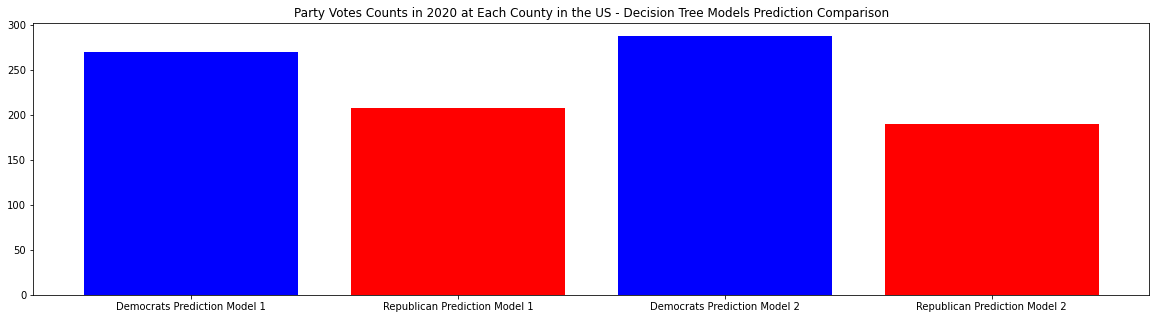

In [32]:
votes = [demo_count1, repu_count1, demo_count2, repu_count2]
names = ['Democrats Prediction Model 1', 'Republican Prediction Model 1', 
         'Democrats Prediction Model 2', 'Republican Prediction Model 2']

plt.figure(figsize=(20, 5))
plt.bar(names, votes, color=['blue', 'red', 'blue', 'red'])
plt.title('Party Votes Counts in 2020 at Each County in the US - Decision Tree Models Prediction Comparison')

![](https://pbs.twimg.com/media/Emuiuk7W4AA2MfT.jpg)